In [61]:
import pandas as pd
import seaborn as sns
import warnings
sns.set(style="whitegrid", palette="muted", font_scale=1)
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
warnings.filterwarnings('ignore')

In [28]:
region = 'Midwest'

In [29]:
df = pd.read_csv(f'/Users/victoriashi/DataspellProjects/LTV_DataSci_Capstone_Project/VS_processed_region_data/{region}.csv', parse_dates=True, index_col='date')

In [30]:
df.drop(columns = ['county_fips', 'state_fips', 'state_name'], inplace=True)

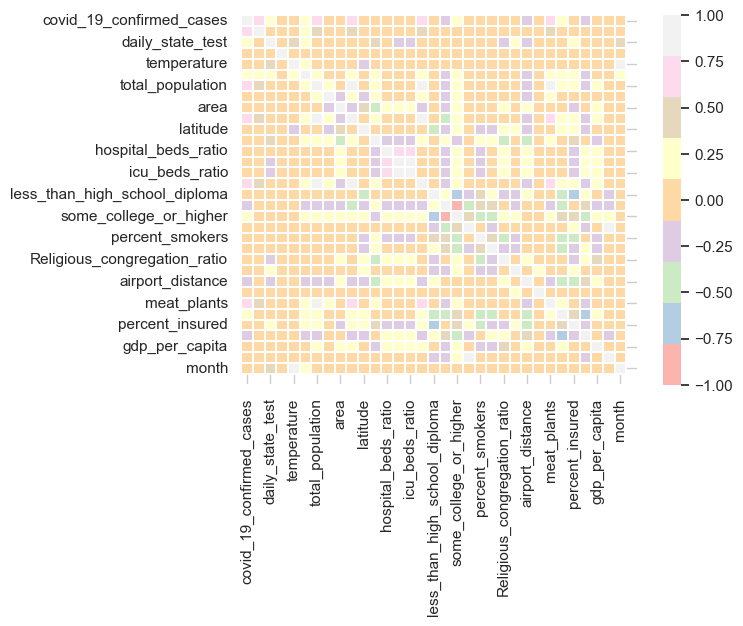

In [46]:
# exclude all columns beginning with "age_"
df_no_age = df[df.columns.drop(list(df.filter(regex='age_')))]
# correlation matrix
corr = df_no_age.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap='Pastel1', vmin=-1, vmax=1, linewidths=0.2, annot_kws={"size": 0.5})
plt.show()

Text(0.5, 0, 'Date')

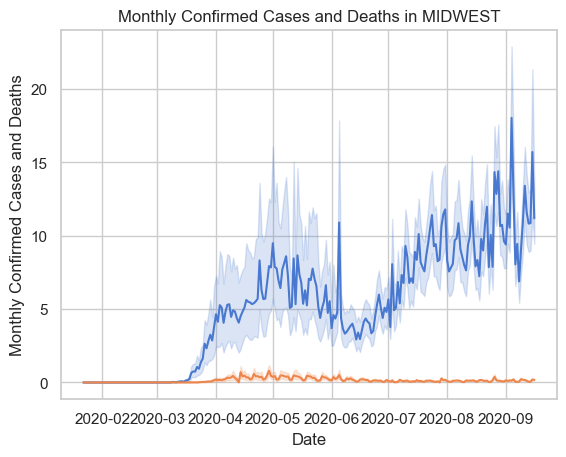

In [47]:
# plot monthly confirmed cases and deaths
sns.lineplot(x=df.index, y='covid_19_confirmed_cases', data=df)
# death
sns.lineplot(x=df.index, y='covid_19_deaths', data=df)
plt.title(f'Monthly Confirmed Cases and Deaths in {region.upper()}')
plt.ylabel('Monthly Confirmed Cases and Deaths')
plt.xlabel('Date')

### Check for Stationarity using ADF test

In [49]:
# Check for Stationarity using ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'{key}: {value}')

In [53]:
# find the daily confirmed case in the previous two weeks
# df['1D_cases'] = df['covid_19_confirmed_cases'].diff(periods=1)
df['1W_cases'] = df['covid_19_confirmed_cases'].diff(periods=7)
adf_test(df['covid_19_confirmed_cases'].dropna())

ADF Statistic: -25.754173533622495
p-value: 0.0
1%: -3.430382586450176
5%: -2.8615544027800732
10%: -2.5667776660819697


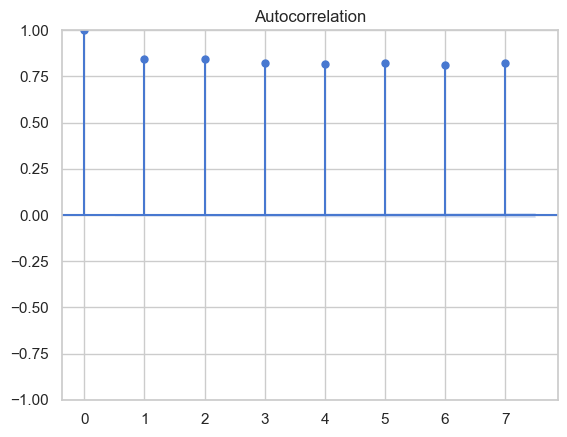

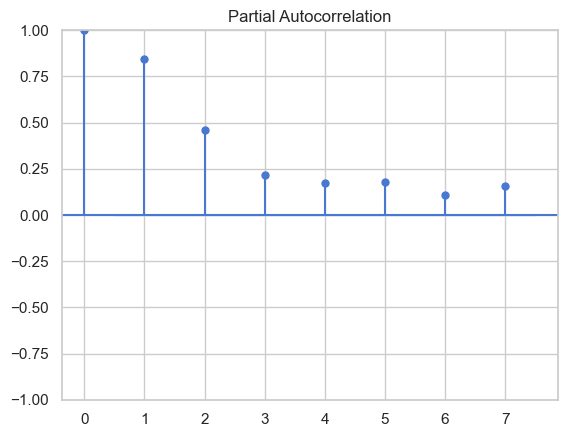

In [54]:
plot_acf(df['covid_19_confirmed_cases'], lags=7)
plot_pacf(df['covid_19_confirmed_cases'], lags=7)
plt.show()

In [ ]:
from pmdarima.arima import auto_arima
# use auto_arima() to predict the confirmed case next day using dataa vailable one week before df['1W_cases']
ar1 = auto_arima(df['covid_19_confirmed_cases'], start_p=1, start_q=1,
           max_p=3, max_q=3, m=7,
           start_P=0, seasonal=True,
           d=1, D=1, trace=True,
           error_action='ignore',
           suppress_warnings=True,
           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=49.06 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1853640.880, Time=1.62 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1744207.362, Time=14.07 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=25.33 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=1798469.889, Time=2.01 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=1719968.387, Time=36.65 sec


In [55]:
# fit the best model ARIMA(1,1,0)(2,1,0)
model2 = ARIMA(df['covid_19_confirmed_cases'], order=(0,2,0)).fit()

In [56]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:     covid_19_confirmed_cases   No. Observations:               200760
Model:                       ARIMA(0, 2, 0)   Log Likelihood             -982276.849
Date:                      Fri, 20 Oct 2023   AIC                        1964555.698
Time:                              03:02:04   BIC                        1964565.908
Sample:                                   0   HQIC                       1964558.703
                                   - 200760                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1040.8508      0.077   1.35e+04      0.000    1040.699    1041.002
===================================================================================
Ljung-Box (L1) (Q):               95964.05   Jarque-Bera (JB):      109259081995.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                           -18.84
Prob(H) (two-sided):                  0.00   Kurtosis:                      3616.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

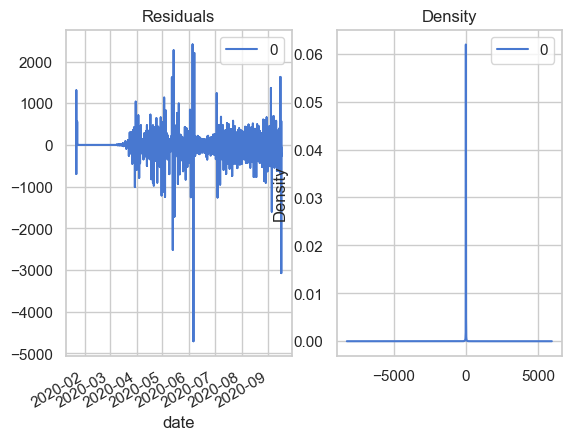

In [57]:
# plot the residual
residuals = pd.DataFrame(model2.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
ar2 = auto_arima(df['covid_19_confirmed_cases'], start_p=1, start_q=2,
                 max_p=3, max_q=3,max_order=3,information_criterion='bic',
                 d=1, D=1, trace=True,
                 error_action='ignore',
                 stepwise=True)

Performing stepwise search to minimize bic
